In [ ]:
import sys
sys.path.append('/iopsstor/scratch/cscs/stefschu/DSM500/github/fourcastnet-93360c1')
import matplotlib.pyplot as plt


import hydra
with hydra.initialize(config_path="..", version_base="1.3"):
    cfg = hydra.compose(config_name="config_new")
from modulus.launch.logging import PythonLogger
from modulus.distributed import DistributedManager
DistributedManager.initialize()
dist = DistributedManager

# FIXIT: Move it under modulus
from inference import Inference

logger = PythonLogger("main")
logger.file_logging()
DistributedManager.initialize()

inference = Inference(cfg, logger)

_, datapipe = inference.load_model_and_datapipe()

# =============================================================================
import torch
import numpy as np
from utils.YParams import YParams

from networks.afnonet import AFNONet
from collections import OrderedDict

def load_model(model, params, checkpoint_file):
    model.zero_grad()
    checkpoint_fname = checkpoint_file
    checkpoint = torch.load(checkpoint_fname)
    try:
        new_state_dict = OrderedDict()
        for key, val in checkpoint['model_state'].items():
            name = key[7:]
            if name != 'ged':
                new_state_dict[name] = val  
        model.load_state_dict(new_state_dict)
    except:
        model.load_state_dict(checkpoint['model_state'])
    model.eval()
    return model

params = YParams(cfg.inference_fcn.yparam_config_file_path, "afno_backbone")
params['weights'] = cfg.inference_fcn.weights_file_path

params["perturb"] = False
params["ics_type"] = 'default'
params['global_batch_size'] = 1
params['resuming'] = False
params['N_in_channels'] = cfg.sample.channels - 1
params['N_out_channels'] = cfg.sample.channels - 1
in_channels = list(range(params['N_in_channels']))
out_channels = list(range(params['N_out_channels']))
params.means = np.load(params.global_means_path)[0, in_channels]
params.stds = np.load(params.global_stds_path)[0, out_channels]

torch.backends.cudnn.benchmark = True

model = AFNONet(params).to(torch.cuda.current_device())
model = load_model(model, params, cfg.inference_fcn.weights_file_path)
model = model.to(torch.cuda.current_device())

/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/distributed/manager.py:346: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(
/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/distributed/manager.py:329: UserWarning: Distributed manager is already intialized
  warn("Distributed manager is already intialized")
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/tmp/ipykernel_233700/3817649652.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://gith

In [2]:
import torch


checkpoint = torch.load("/iopsstor/scratch/cscs/stefschu/DSM500/github/experiments/02-Baseline/checkpoints_old/model.iter007000.pth")
checkpoint["metadata"]["__name__"] = "GraphCastNetBaseline"
checkpoint["metadata"]["__module__"] = "modulus.models_baseline.graphcast.graph_cast_net"

torch.save(checkpoint, "/iopsstor/scratch/cscs/stefschu/DSM500/github/experiments/02-Baseline/checkpoints/model.iter007000.pth")

/tmp/ipykernel_42591/3316873686.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/iopsstor/scratch/cscs/stefschu/DSM500/github/experiments/02-Bas

In [3]:
data = next(iter(datapipe))
data = data[0]

In [28]:
input = data["input"].cpu()
input = input[:, :, :21]
input = input * datapipe.stds + datapipe.means

from modulus.datapipes.climate.era5_hdf5_newest import fix_latitude_alignment
input = fix_latitude_alignment(input)

print(input.device, input.dtype, input.shape)

global_sample_id = data["global_sample_id"].item()
print(global_sample_id)

cpu torch.float32 torch.Size([1, 1, 21, 721, 1440])
697


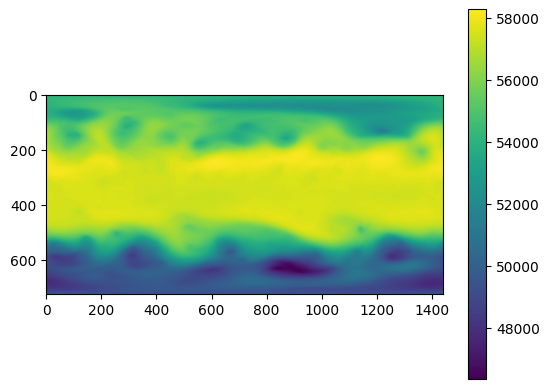

In [29]:
import matplotlib.pyplot as plt

im = plt.imshow(input[0, 0, 14].cpu().numpy())
plt.colorbar(im)
plt.show()

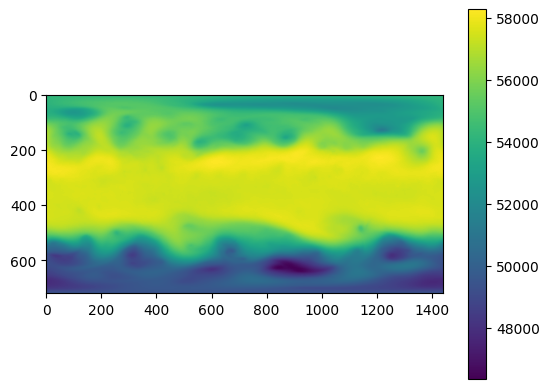

In [51]:
import h5py

with h5py.File("/iopsstor/scratch/cscs/stefschu/DSM500/data/FCN_ERA5_data_v0/out_of_sample/2018.h5", 'r') as f:
    input_fresh = torch.tensor(f['fields'][global_sample_id, :20, :720]).unsqueeze(0)

im = plt.imshow(input_fresh[0, 14])
plt.colorbar(im)
plt.show()

In [50]:
input_fresh.shape

torch.Size([1, 20, 720, 1440])

In [53]:
input_fresh_norm = (input_fresh - params.means) / params.stds
input_fresh_norm = input_fresh_norm.to(dtype=torch.float32)
input_fresh_norm.shape, input_fresh_norm.dtype

(torch.Size([1, 20, 720, 1440]), torch.float32)

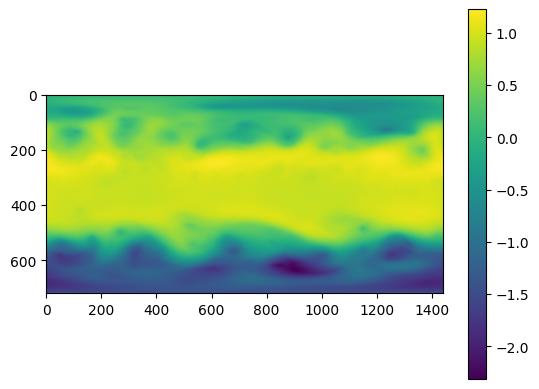

Process SpawnProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 462, in worker
    scheduled, shm_chunk = worker_context.get_task()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 434, in get_task
    scheduled_meta = self.task_receiver.get_task()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 132, in get_task
    recv = self.queue.get()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/shared_queue.py", line 171, in get
    waited = self._wait_for_samples()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/shared_queue.py", line 99, in _wait_for_samples
    self.cv_not_e

In [55]:
output = model(input_fresh_norm.to(torch.cuda.current_device()))
im = plt.imshow(output[0, 14].detach().cpu())
plt.colorbar(im)
plt.show()

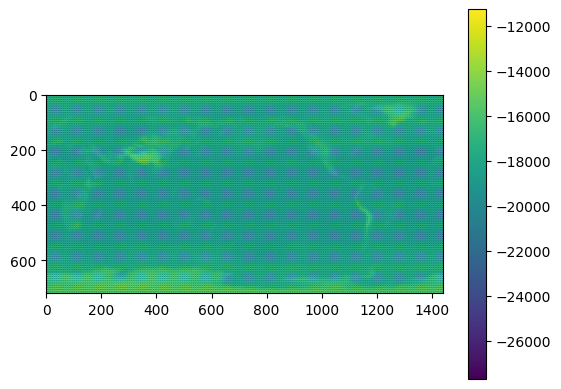

Process SpawnProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 462, in worker
    scheduled, shm_chunk = worker_context.get_task()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 434, in get_task
    scheduled_meta = self.task_receiver.get_task()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 132, in get_task
    recv = self.queue.get()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/shared_queue.py", line 171, in get
    waited = self._wait_for_samples()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/shared_queue.py", line 99, in _wait_for_samples
    self.cv_not_e

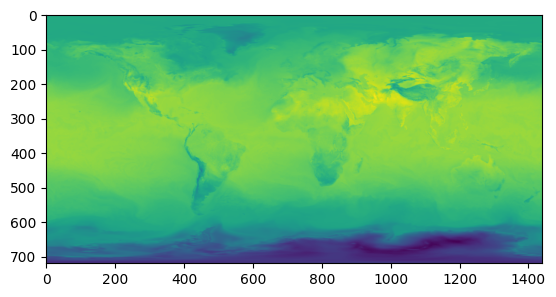

In [25]:
plt.imshow(input[0, 0, 2, :720].detach().cpu().numpy())
plt.show()

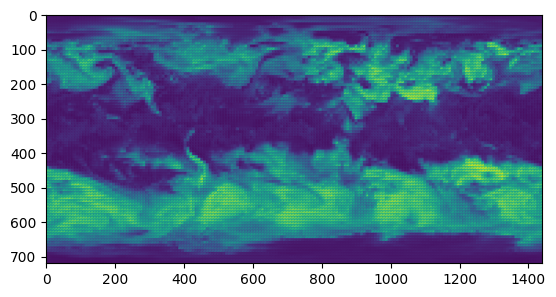

In [26]:
import matplotlib.pyplot as plt

plt.imshow(output[0, 2].detach().cpu().numpy())
plt.show()

In [1]:
import h5py 

with h5py.File("/iopsstor/scratch/cscs/stefschu/DSM500/github/fourcastnet-93360c1/output/autoregressive_predictions_z500.h5", 'r') as f:
    print(f.keys()  )

<KeysViewHDF5 ['acc', 'acc_coarse', 'acc_coarse_unweighted', 'acc_unweighted', 'rmse', 'rmse_coarse']>


In [ ]:
valid_data_full = h5py.File("/iopsstor/scratch/cscs/stefschu/DSM500/data/FCN_ERA5_data_v0/out_of_sample/2018.h5", 'r')['fields']

valid_data = valid_data_full[ic:(ic+prediction_length*dt+n_history*dt):dt, in_channels, 0:720]

In [7]:

import sys
sys.path.append('/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8')
sys.path.append('/iopsstor/scratch/cscs/stefschu/DSM500/github/fourcastnet-93360c1')

from modulus.distributed import DistributedManager
DistributedManager.initialize()

import numpy as np
import torch

from omegaconf import OmegaConf
import matplotlib.pyplot as plt

cfg = OmegaConf.load("/iopsstor/scratch/cscs/stefschu/DSM500/github/inference/inference_config.yaml")

from inference import Inference

inference = Inference(cfg)

model, datapipe = inference.load_fourcastnet()

/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/distributed/manager.py:346: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(
/iopsstor/scratch/cscs/stefschu/DSM500/github/fourcastnet-93360c1/fourcastnet/inference/inference.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

In [8]:
data = next(iter(datapipe))
data = data[0]
data.keys()

/usr/local/lib/python3.10/dist-packages/nvidia/dali/pipeline.py:912: Warning: The external source node '<modulus.datapipes.climate.era5_hdf5.ERA5DaliExternalSourceNew object at 0xfffb9dcfaf80>' produces 6 outputs, but the output at the index 4 is not used. For best performance, adjust your callback so that it computes only the needed outputs.
  warnings.warn(


dict_keys(['epoch_idx', 'output', 'timestamps', 'input', 'idx_in_epoch', 'global_sample_id'])

In [9]:
output = model(data["input"])
output.shape

torch.Size([1, 20, 720, 1440])

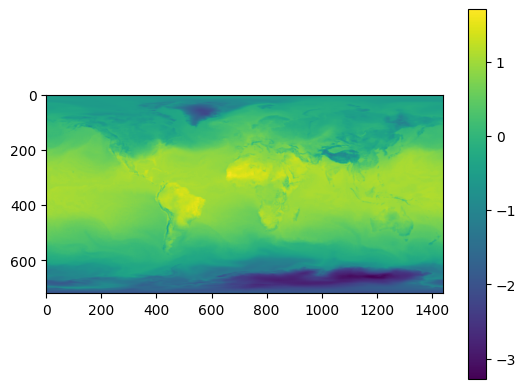

In [10]:
im = plt.imshow(output[0, 2].detach().cpu().numpy())
plt.colorbar(im)
plt.show()